In [1]:
# geladene Bibliotheken und Funktionen
import numpy as np
from sympy import *
from sympy.physics.vector import *
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import solve_ivp
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Line Magics 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
m, g, R, t, v0 = symbols('m, g, R, t, v0')
x = Function('x')(t)
y = Function('y')(t)

Wir definieren zunächst ein Koordinatensystem:

In [3]:
E = ReferenceFrame('E') 

#### Orts- und Geschwindigkeitsvektoren

In [4]:
r = x*E.x + y*E.y
v = r.diff(t,E) # Ableitung des Vektors r nach t im KOS E
r
v

x(t)*E.x + y(t)*E.y

Derivative(x(t), t)*E.x + Derivative(y(t), t)*E.y

#### Lagrangefunktion

In [5]:
L = 1/2*m*dot(v,v) - m*g*dot(r,E.y)
L

-g*m*y(t) + 0.5*m*(Derivative(x(t), t)**2 + Derivative(y(t), t)**2)

#### Zwangsbedingung

In [6]:
gg = x**2 + y**2 - R**2 
gg

-R**2 + x(t)**2 + y(t)**2

In [7]:
l = Function('lambda')(t)

#### Bewegungsgleichungen

In [8]:
odes = [Eq(diff(L,diff(z,t),t) - diff(L,z), l*diff(gg,z)) for z in [x,y]]
Array(odes)

[Eq(1.0*m*Derivative(x(t), (t, 2)), 2*lambda(t)*x(t)), Eq(g*m + 1.0*m*Derivative(y(t), (t, 2)), 2*lambda(t)*y(t))]

Die Details nachfolgender Implementierung können in Mehrkörpersysteme von Woernle S. 147-149 und S. 186-188 nachgelesen werden.

In [9]:
### siehe Woernle, Mehrkörpersysteme S. 147-149, 186-188
param = {R: 2, g: 9.81, m:1, v0: 9.5}


r_mat = Matrix([x,y])
v_mat = diff(r_mat, t)
g_mat = Matrix([gg])

#alpha, beta = symbols('alpha, beta') # Baumgarte-Stabilisierungsparameter
alpha = beta = 10
M = m*eye(2) # Massenmatrix
fe = Matrix([0, -m*g]) # eingeprägte Kräfte
G = g_mat.jacobian(r_mat) # Jacobi-Matrix dg/dr
Q = G*M.inv()*G.T

# alte Variablen 
old = Matrix.vstack(r_mat, v_mat)
# neue Variablen 
new = symbols('x1:'+str(len(old)+1))

# die folgenden beiden dicts werden für die partielle Ableitung von g nach t benötigt
dummy = dict(zip(r_mat, new[:len(new)//2]))
ymmud = dict((v,k) for k,v in dummy.items()) # keys und values von dummy getauscht

gam_bb = diff(G,t) * v_mat + diff(g_mat.subs(dummy),t).subs(ymmud) # dG/dt*v + \partial g/\partial t


## Aufbau des DGL-Systems nach Woernle, S. 149, Gl. (5.70) mit Stabilisierung nach Baumgarte S. 187f

# erster Teil des DGL-Systems: dr/dt = part1
teil1 = v_mat
# zweiter Teil: dv/dt = part2
lam = -Q.inv()*(G*M.inv()*fe + gam_bb + 2*alpha*diff(g_mat,t) + beta**2*g_mat) # Lagrange-Multiplikator
teil2 = M.inv()*(fe+G.T*lam)
#Alternative: part2 = M.inv()*(eye(2) - G.T*Q.inv()*G*M.inv())*fe - M.inv()*G.T*Q.inv()*(gam_bb + 2*alpha*diff(g_mat,t) + beta**2*g_mat)

# Gesamtes DGL-System: [dr/dt dv/dt]^T = dglSystem
dglSystem = Matrix.vstack(teil1,teil2)

# ersetze x,y und ihre Ableitungen, sowie Parameter
old2new = dict(zip(old,new))
RHS = dglSystem.subs({**old2new,**param})

normalkraft = (lam*sqrt(G.dot(G))).subs({**param,**old2new})


X = new
f = lambdify([t, X], np.array(RHS).flatten()) # rechte Seite des DGL-Systems für solve_ivp 

# Event des Abhebens
abheben = lambdify([t,X], normalkraft) # Abheben: Normalkraft = 0
abheben.terminal = True # stoppe numerische Integration bei Eintritt des Events


In [10]:
# vor Abheben
tspan = [0, 10]
# Anfangsbedingungen
x0 = 0
y0 = -R
vx0 = v0
vy0 = 0

Y0 = Matrix([x0, y0, vx0, vy0]).subs(param)
Y0 = np.array(Y0).astype(np.float64).flatten()
sol=solve_ivp(f,tspan,Y0,events=abheben,rtol=1e-9,atol=1e-12,t_eval=np.linspace(*tspan,1000))

# nach Abheben
RHS2 = Matrix([X[2], X[3], 0, -g]).subs(param)
f2 = lambdify([t, X], np.array(RHS2).flatten())
aufprall = lambdify([t, X], gg.subs({**param,**old2new}))
aufprall.terminal = True
aufprall.direction = 1
tspan2 = [sol.t[-1], tspan[-1]]
x1 = sol.y[0,-1]
y1 = sol.y[1,-1]
vx1 = sol.y[2,-1]
vy1 = sol.y[3,-1]
Y1 = Matrix([x1, y1, vx1, vy1])
Y1 = np.array(Y1).astype(np.float64).flatten()
sol2 = solve_ivp(f2,tspan2,Y1,rtol=1e-9,atol=1e-12,events=aufprall,t_eval=np.linspace(*tspan2,1000))


InteractiveShell.ast_node_interactivity = "last"

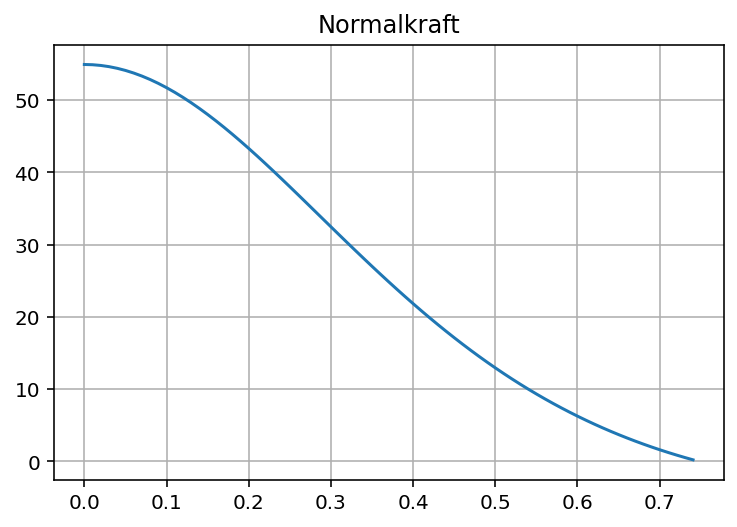

In [11]:
plt.plot(sol.t,-abheben(0,sol.y).flatten())
plt.title('Normalkraft')
plt.grid()
plt.show()

In [12]:
def ring(param,number_of_points=100):
    phi_values = np.linspace(0,2*np.pi,number_of_points)
    x_values = R.subs(param)*np.cos(phi_values)
    y_values = R.subs(param)*np.sin(phi_values)
    return [x_values, y_values]

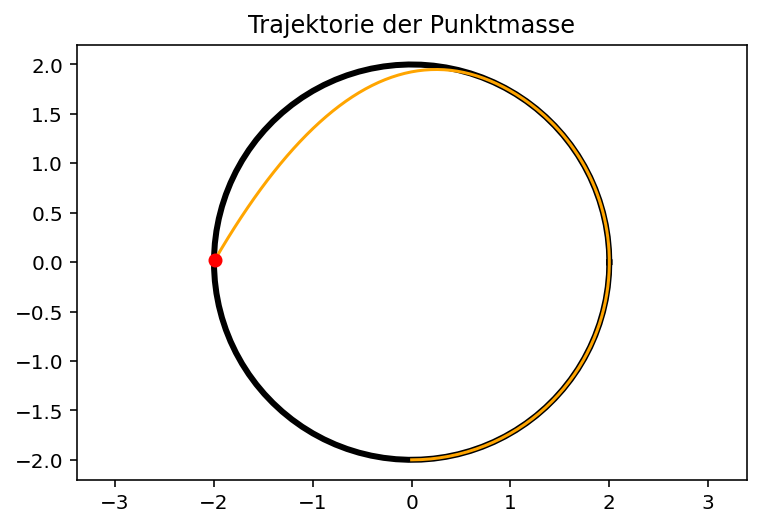

In [13]:
x_vals = np.concatenate([sol.y[0,:], sol2.y[0,:]])
y_vals = np.concatenate([sol.y[1,:], sol2.y[1,:]])
[x_ring, y_ring] = ring(param)

plt.plot(x_ring,y_ring,'k',linewidth=3)
plt.plot(x_vals, y_vals,color='orange')
plt.plot(sol2.y[0,-1],sol2.y[1,-1],'ro')
plt.axis('equal')
plt.title('Trajektorie der Punktmasse')
plt.show()

In [14]:
%matplotlib widget


fig, ax = plt.subplots(figsize=(7,7))

line_ring, = ax.plot([],'k',linewidth=3)
line_traj, = ax.plot([],'.8',linestyle='dashed')
line_masspoint, = ax.plot([],'ro')


x_ring = 2*np.cos(np.linspace(0,2*np.pi,100))
y_ring = 2*np.sin(np.linspace(0,2*np.pi,100))
line_ring.set_data((x_ring, y_ring))

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

def animate(frame_num):
    x_point = x_vals[frame_num]
    y_point = y_vals[frame_num]
        
    line_masspoint.set_data((x_point, y_point))
    line_traj.set_data((x_vals[:frame_num], y_vals[:frame_num]))
    return line_masspoint, line_traj


anim = FuncAnimation(fig, animate, frames=len(x_vals), interval=20, blit=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
def odeToVectorField(odes, var):
    """Überführt Bewegungsgleichungen (a.k.a. ODE-System 2. Ordnung) in ODE-System 1. Ordnung (für numerische Solver).
    
    Ausgabe: 
    1. neue symbolische Variablen x1, ..., xN (generalisierte Koordinaten, dann generalisierte Geschwindigkeiten)
    2. rechte Seite als ODE-System 1. Ordnung"""
    if type(odes) != type(list()):
        odes = [odes]
        var = [var]
    rhs = Array([*diff(Array(var),t), *solve(odes,diff(Array(var),t,t)).values()])
    old = list(np.array([var, diff(Array(var),t)]).flatten())
    new = symbols('x1:'+str(len(old)+1))
    return [new, rhs.subs(dict(zip(old,new)))]


In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Um den Code sichtbar zu machen, klicken Sie hier."></form>''')